In [182]:
import tensorflow as tf
import sklearn
import glob
import cv2
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, Flatten, Input, Conv2D, MaxPooling2D, Lambda
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from sklearn.model_selection import train_test_split
from skimage.transform import resize



In [183]:
benign_dataset =  glob.glob('../benigns/*.png)
malign_dataset = glob.glob("../malings/*.png") 

                            
                            

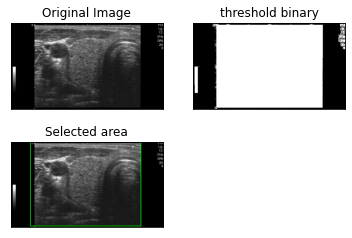

array([[[ 2,  2,  2],
        [ 1,  1,  1],
        [ 4,  4,  4],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 1,  1,  1],
        [ 5,  5,  5],
        [ 6,  6,  6],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 2,  2,  2],
        [ 8,  8,  8],
        [ 6,  6,  6],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [27, 27, 27],
        [26, 26, 26],
        [ 3,  3,  3]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [16, 16, 16],
        [16, 16, 16],
        [ 2,  2,  2]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 0,  0,  0]]], dtype=uint8)

In [199]:
import copy
import cv2
import random
from matplotlib import pyplot as plt

def preprocess(path):


    IMG_IN = path


    # keep a copy of original image
    original = cv2.imread(IMG_IN)

    # Read the image, convert it into grayscale, and make in binary image for threshold value of 1.
    img = cv2.imread(IMG_IN,0)

    # use binary threshold, all pixel that are beyond 3 are made white
    _, thresh_original = cv2.threshold(img, 3, 255, cv2.THRESH_BINARY)

    # Now find contours in it.
    thresh = copy.copy(thresh_original)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    # get contours with highest height
    lst_contours = []
    for cnt in contours:
        ctr = cv2.boundingRect(cnt)
        lst_contours.append(ctr)
    x,y,w,h = sorted(lst_contours, key=lambda coef: coef[3])[-1]
    ROI = original[y:y+h, x:x+w]




    # draw contours
    ctr = copy.copy(original)
    cv2.rectangle(ctr, (x,y),(x+w,y+h),(0,255,0),2)

    # display results with matplotlib

    # original
    original = original[:,:,::-1] # flip color for maptolib display
    plt.subplot(221), plt.imshow(original)
    plt.title('Original Image'), plt.xticks([]),plt.yticks([])

    # Threshold
    plt.subplot(222), plt.imshow(thresh_original, cmap='gray')
    plt.title('threshold binary'), plt.xticks([]),plt.yticks([])

    # selected area for future crop
    ctr = ctr[:,:,::-1] # flip color for maptolib display
    plt.subplot(223), plt.imshow(ctr)
    plt.title('Selected area'), plt.xticks([]),plt.yticks([])

    #plt.close("all") #comment to see all images

    plt.show()
    
    return ROI

cropped_benign_images = []
for path in benign_dataset:
    cropped_benign_image = preprocess(path)
    cropped_benign_images.append(cropped_benign_image)
    

cropped_malign_images = []
for path in malign_dataset:
    cropped_malign_image = preprocess(path)
    cropped_malign_images.append(cropped_malign_image)

    
#Example Image
    
bening = "/home/furkan/Downloads/benigns/1.png"
preprocess(bening)

In [191]:
import numpy as np

def save_ROI(cropped_images):

    images = np.array(cropped_images)

    for i in range(0,(images.shape[0])):
        cv2.imwrite("../dataset/"+str(i)+".png",cropped_images[i]) #add cropped images to folder

def resize(images):
    
    res_counter = 0

    for i in images:
        image = cv2.imread(i)
        res = cv2.resize(image , (200,200))
        cv2.imwrite("../resized/{}.png".format(res_counter),res) 
        res_counter += 1



In [ ]:
#Data Augmentation

directory = "../resized "

tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
)


In [176]:
# Importing the important libraries
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# Download the architecture of ResNet50 with ImageNet weights
base_model = ResNet50(include_top=False, weights='imagenet')

#We will try to train the last stage of ResNet50
for layer in base_model.layers[0:143]:
  layer.trainable = False

for layer in base_model.layers[143:]:
  layer.trainable = True


layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_7,False
1,<tensorflow.python.keras.layers.convolutional....,conv1_pad,False
2,<tensorflow.python.keras.layers.convolutional....,conv1_conv,False
3,<tensorflow.python.keras.layers.normalization_...,conv1_bn,False
4,<tensorflow.python.keras.layers.core.Activatio...,conv1_relu,False
...,...,...,...
170,<tensorflow.python.keras.layers.core.Activatio...,conv5_block3_2_relu,True
171,<tensorflow.python.keras.layers.convolutional....,conv5_block3_3_conv,True
172,<tensorflow.python.keras.layers.normalization_...,conv5_block3_3_bn,True
173,<tensorflow.python.keras.layers.merge.Add obje...,conv5_block3_add,True


In [178]:

model = Sequential()
model.add(base_model)

model.add(Dense(512, activation='relu', input_dim=(200,200,3)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

sgd = optimizers.SGD(lr=0.0001, clipvalue=0.5)

model.compile(loss='binary_crossentropy',
              optimizer= sgd,
            
              metrics=['accuracy'])

history = model.fit(X_train,Y_train,batch_size=4, epochs=10,
                              validation_data=(X_val,Y_val), 
                              verbose=1)     

Epoch 1/10
320/320 [==============================] - 972s 3s/step - loss: 0.8136 - accuracy: 0.5861 - val_loss: 0.5490 - val_accuracy: 0.7437
Epoch 2/10
320/320 [==============================] - 940s 3s/step - loss: 0.5822 - accuracy: 0.6900 - val_loss: 0.4750 - val_accuracy: 0.7844
Epoch 3/10
320/320 [==============================] - 778s 2s/step - loss: 0.4559 - accuracy: 0.7833 - val_loss: 0.4227 - val_accuracy: 0.7969
Epoch 4/10
320/320 [==============================] - 777s 2s/step - loss: 0.3710 - accuracy: 0.8345 - val_loss: 0.3875 - val_accuracy: 0.8094
Epoch 5/10
320/320 [==============================] - 885s 3s/step - loss: 0.2791 - accuracy: 0.8911 - val_loss: 0.3687 - val_accuracy: 0.8094
Epoch 6/10
320/320 [==============================] - 835s 3s/step - loss: 0.2600 - accuracy: 0.8832 - val_loss: 0.3614 - val_accuracy: 0.8281
Epoch 7/10
320/320 [==============================] - 783s 2s/step - loss: 0.2518 - accuracy: 0.8996 - val_loss: 0.3318 - val_accuracy: 0.8469

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


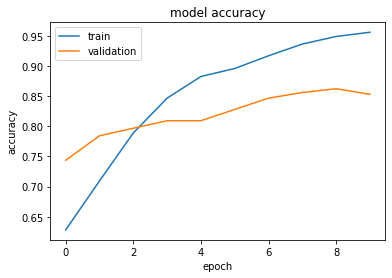

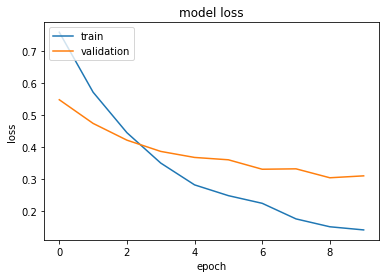

In [179]:
history= history
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [180]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

prediction=model.predict_classes(X_test,verbose=1)

matrix = confusion_matrix(Y_test, prediction)
print(matrix)

report = classification_report(Y_test, prediction)
print(report)

13/13 [==============================] - 114s 8s/step
[[226  26]
 [ 19 129]]
              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91       252
         1.0       0.83      0.87      0.85       148

    accuracy                           0.89       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.89      0.89      0.89       400



In [181]:
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix

cm1 = matrix
total1=sum(sum(cm1))
print('Confusion Matrix : \n', cm1)

#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Confusion Matrix : 
 [[226  26]
 [ 19 129]]
Accuracy :  0.8875
Sensitivity :  0.8968253968253969
Specificity :  0.8716216216216216
